In [1]:
import sys
from simple_simulation_inverse_search import gates_set, matrix_list, add_inverse_gates
from simple_simulation_hardware import simple_processor, simple_compiler
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from qutip_qip.compiler import GateCompiler, Instruction
from qutip_qip.device import ModelProcessor
from qutip import (sigmax, sigmay, tensor)

import functools # for reduce
from qutip.qip.operations.gates import *
from qutip import basis
from qutip_qip.circuit import QubitCircuit
from qutip.metrics import fidelity
from qutip.qip.noise import RandomNoise

In [3]:
V = 1
omega = 10e6 # 10MHz

# Decoherence time
T1 = 8.66e-6
T1_err = 0.49
T2 = 9.08e-6
T2_err = 0.74e-6
T2_echo = 16.14e-6
T2_echo_err = 3.21e-6

In [4]:
def NTU_single_simple_simulation(num_gates, t1 = None, t2 = None, num_qubits = 1, 
                            add_FPGA_noise = False, FPGA_noise_strength = 0.3, 
                            pulse_amplitude = 1):
    """
    A single simulation, with num_gates representing the number of rotations.

    Args:
        num_gates (int): The number of random gates to add in the simulation.
        t1, t2 (float): Decoherence time of the qubits.
        add_FPGA_noise (bool): Whether to add in gaussian FPGA noise to the simulation.

    Returns:
        final_fidelity (float):
            Fidelity of the result state (obtained from 
            mesolve solver method) and the initial state.
    """
     
    myprocessor = simple_processor(num_qubits, t1 = t1, t2 = t2)
    myprocessor.native_gates = None  # Remove the native gates
    mycompiler = simple_compiler(num_qubits,{"pulse_amplitude": pulse_amplitude})

    # Ground state for n qubits
    init_state = functools.reduce(lambda a, b: tensor(a,b), [basis(2, 0)] * num_qubits)

    # Define a random circuit.
    circuit = QubitCircuit(num_qubits)
    clifford = rx(0)
    for ind in np.random.randint(0, 6, num_gates):
        circuit.add_gate(gates_set[ind])
        clifford = matrix_list[ind] * clifford

    # Finding inverse Clifford for the random sequence of gate
    add_inverse_gates(clifford, init_state, circuit = circuit)

    # Simulate the circuit.
    myprocessor.load_circuit(circuit, compiler=mycompiler)
    
    # FPGA gaussian noise
    if add_FPGA_noise == True:
        FPGA_noise = RandomNoise(dt=1e-9, rand_gen=np.random.normal, loc=0.00, scale = FPGA_noise_strength)
        myprocessor.add_noise(FPGA_noise)
    
    # Compute results of the run using a solver of choice
    result = myprocessor.run_state(init_state, solver="mesolve")
    # Measured fidelity at the end
    final_fidelity = fidelity(result.states[0],result.states[-1])
    return final_fidelity


In [6]:
def NTU_simulation_test_run(num_gates_list, num_sample, 
                        add_FPGA_noise = False, FPGA_noise_strength = 0.3, 
                        t1 = None, t2 = None,
                        pulse_amplitude = V*omega):
    fidelity_average = []
    fidelity_error = []
    for num_gates in num_gates_list:
        fidelity_list = [NTU_single_simple_simulation(
            num_gates, t1 = t1, t2 = t2, 
            add_FPGA_noise = add_FPGA_noise,
            FPGA_noise_strength = FPGA_noise_strength,
            pulse_amplitude = 10e6
            ) for i in range(num_sample)]
        fidelity_average.append(np.mean(fidelity_list))
        fidelity_error.append(np.std(fidelity_list) / np.sqrt(num_sample))
    
    return fidelity_average, fidelity_error

## Plot baseline vs with FPGA noise and decoherence

In [7]:
num_sample = 10
#num_gates_list = np.linspace(1,300,25,dtype=int)
num_gates_list = np.arange(5,105,20)

In [8]:
fidelity_baseline, error_baseline = NTU_simulation_test_run(
    num_gates_list, num_sample, 
    add_FPGA_noise = False, t1 = None, t2 = None)
fidelity_t1t2, error_t1t2 = NTU_simulation_test_run(
    num_gates_list, num_sample, 
    add_FPGA_noise = False, t1 = T1, t2 = T2)
fidelity_FPGA, error_FPGA = NTU_simulation_test_run(
    num_gates_list, num_sample, 
    add_FPGA_noise = True, t1 = None, t2 = None)
fidelity_FPGA_t1t2, error_FPGA_t1t2 = NTU_simulation_test_run(
    num_gates_list, num_sample, 
    add_FPGA_noise = True, t1 = T1, t2 = T2)

Text(0, 0.5, 'Ground State Fidelity')

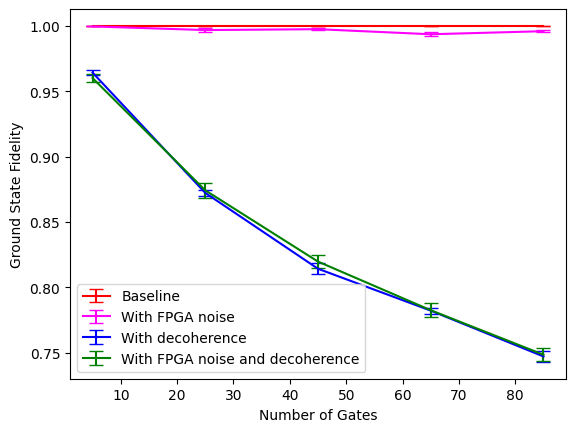

In [9]:
plt.autoscale(enable=True, axis="y", tight=False)
plt.errorbar(num_gates_list, fidelity_baseline, yerr=error_baseline, 
             color='red', capsize=5,label = 'Baseline')
plt.errorbar(num_gates_list, fidelity_FPGA, yerr=error_FPGA, 
             color='magenta', capsize=5, label = 'With FPGA noise')
plt.errorbar(num_gates_list, fidelity_t1t2, yerr=error_t1t2, 
             color='blue', capsize=5, label = 'With decoherence')
plt.errorbar(num_gates_list, fidelity_FPGA_t1t2, yerr=error_FPGA_t1t2, 
             color='green', capsize=5, label = 'With FPGA noise and decoherence')
plt.legend()
plt.xlabel("Number of Gates")
plt.ylabel("Ground State Fidelity")

## Plot fidelity of different noise strength

In [10]:
my_dict = {}
dictionary_key = []
for noise_strength in np.linspace(1/8000,1,20):
    fidelity_FPGA_t1t2, error_FPGA_t1t2 = NTU_simulation_test_run(
    num_gates_list, num_sample, 
    add_FPGA_noise = True, FPGA_noise_strength = noise_strength,
    t1 = 8.66e-6, t2 = 9.08e-6)
    dictionary_key = f"FPGA noise strength = {int(noise_strength*8000)}"
    my_dict[dictionary_key] = [fidelity_FPGA_t1t2, error_FPGA_t1t2]

Text(0, 0.5, 'Ground State Fidelity')

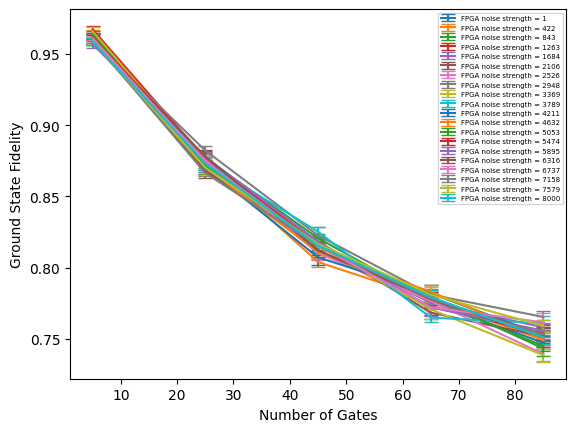

In [11]:
plt.autoscale(enable=True, axis="y", tight=False)
for key in my_dict:
    plt.errorbar(num_gates_list, my_dict[key][0], yerr=my_dict[key][1], 
                capsize=5,label = key)
plt.legend(fontsize="5")
plt.xlabel("Number of Gates")
plt.ylabel("Ground State Fidelity")

## Plot fidelity against FPGA noise for the same number of gates

In [12]:
fidelity_list = []
noise_list = []
error_list = []
for noise_strength in np.linspace(1/8000,1,20):
    fidelity_FPGA_t1t2, error_FPGA_t1t2 = NTU_simulation_test_run(
    [30], 30, 
    add_FPGA_noise = True, FPGA_noise_strength = noise_strength,
    t1 = 8.66e-6, t2 = 9.08e-6)
    fidelity_list.append(fidelity_FPGA_t1t2)
    noise_list.append(noise_strength)
    error_list.append(error_FPGA_t1t2)

Text(0, 0.5, 'Ground State Fidelity')

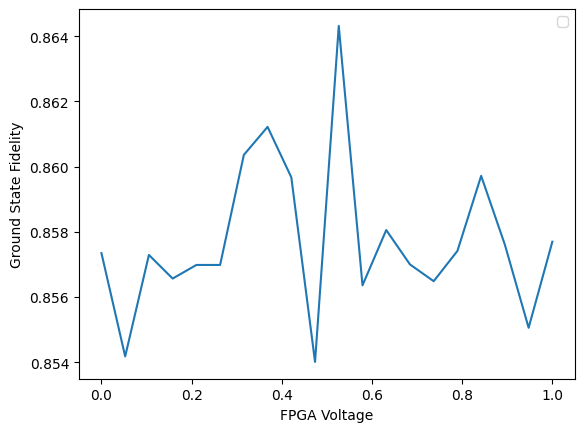

In [13]:
plt.autoscale(enable=True, axis="y", tight=False)
plt.plot(noise_list,fidelity_list)

plt.legend()
plt.xlabel("FPGA Voltage")
plt.ylabel("Ground State Fidelity")